In [513]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from  sklearn.model_selection import train_test_split
import lightgbm as lgb
from bubbly.bubbly import bubbleplot
from plotly.offline import iplot
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.metrics import confusion_matrix 
import pylab as pl
pd.set_option('mode.chained_assignment', None)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [514]:
root = "/Users/dingjunlu/PycharmProjects/DataMiningCompetition/Risk_Prediction_Of_Illegal_Fund_Raising/data/"
path_base_info = root + "train/base_info.csv"
path_annual_report_info = root + "train/annual_report_info.csv"
path_change_info = root + "train/change_info.csv"
path_news_info = root + "train/news_info.csv"
path_other_info = root + "train/other_info.csv"
path_tax_info = root + "train/tax_info.csv"
path_entprise_evaluate = root + "entprise_evaluate.csv"
path_entprise_info = root + "train/entprise_info.csv"

In [545]:
class BaseInfo:
    def __init__(self, data, type='train'):
        self.data = data
        self.data_type = {
            'opfrom': 'time',
            'opto': 'time',
            'reccap': 'int64',
            'enttypeminu': 'category',
            'venind': 'category',
            'enttypeitem': 'category',
            'empnum': 'int64',
            'regcap': 'int64',
            'industryco': 'category',
            'oploc': 'category',
            'oplocdistrict': 'category',
            'regtype': 'category',
            'townsign': 'category',
            'adbusign': 'category',
            'jobid': 'category',
            'orgid': 'category',
            'state': 'category',
            'enttype': 'category',
            'dom': 'category',
            'industryphy': 'category',
            'enttypegb': 'category',
            'opform': 'category'
        }
        self.useless_columns = [
            'ptbusscope',
            'midpreindcode',
            'protype',
            'forreccap',
            'congro',
            'forregcap',
            'exenum',
            'parnum',
            'compform',
            'opscope',
#             'id'

#             'orgid',
#             'industryco',
#             'dom',
#             'enttypegb',
#             'enttypeitem',
#             'opfrom',
#             'state',
#             'adbusign',
#             'jobid',
#             'enttypegb',
#             'regtype',
#             'empnum',
#             'venind',
#             'enttypeminu',
#             'oploc',
#             'enttype',
#             'oplocdistrict'

        ]

        if type == 'test':
            self.useless_columns.remove('id')
            self.useless_columns.append('score')

        return

    def fill_nan(self, name, value, column_type):
        self.data[name] = self.data[name].fillna(value)
        self.data[name] = self.data[name].astype(column_type)
        return

    def label_encoder(self, name, column_type):
        label_encode = LabelEncoder()
        value_data = self.data[self.data[name].isnull() == 0]
        null_data = self.data[self.data[name].isnull() != 0]
        value_data[name] = label_encode.fit_transform(value_data[name])
        self.data = pd.concat([null_data, value_data])
        self.data[name] = self.data[name].astype(column_type)
        return

    def drop_columns(self, drop_columns):
        self.data.drop(drop_columns, axis=1, inplace=True)
        return

    def unify_time(self, name):
        value_data = self.data[self.data[name].isnull() == 0]
        null_data = self.data[self.data[name].isnull() != 0]
        value_data[name] = value_data[name].apply(
            lambda x: x if len(x) > 10 else (x + " 00:00:00"))
        value_data[name] = value_data[name].apply(
            lambda x: x if x is None else datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
        value_data[name] = value_data[name].apply(lambda x: x.year)
        self.data = pd.concat([value_data, null_data])
        return

    def feature_process_v1(self):
        for name in self.data_type.keys():
            if self.data_type.get(name) == 'category':
                self.label_encoder(name,'category')
            elif self.data_type.get(name) == 'int64':
                mean = self.data[self.data[name].isnull() == 0][name].mean()
                self.fill_nan(name, mean, 'int64')
            elif self.data_type.get(name) == 'time':
                self.unify_time(name)
                mode = self.data[name].mode()[0]
                self.fill_nan(name, mode, 'int64')

        self.data['diff_year'] = (self.data['opto'] - self.data['opfrom']).astype('int64')
        self.drop_columns(self.useless_columns)
        return self.data
    
    def feature_process_v2(self):
        for name in self.data_type.keys():
            if self.data_type.get(name) == 'category':
                self.fill_nan(name, '-1', 'str')
                self.label_encoder(name, 'category')
            elif self.data_type.get(name) == 'int64':
                mean = self.data[self.data[name].isnull() == 0][name].mean()
                self.fill_nan(name, mean, 'int64')
            elif self.data_type.get(name) == 'time':
                self.unify_time(name)
                mode = self.data[name].mode()[0]
                self.fill_nan(name, mode, 'int64')

        self.data['diff_year'] = (self.data['opto'] - self.data['opfrom']).astype('int64')
        self.drop_columns(self.useless_columns)
        return self.data
    
def split_data(data_frame, split_ratio):
    label = data_frame[['label']]
    data_frame.drop(['label'], axis=1, inplace=True)
    train_data, val_data, train_label, val_label = train_test_split(data_frame,
                                                                    label,
                                                                    test_size=split_ratio,
                                                                    random_state=2020)
    return train_data, val_data, train_label, val_label



def get_balance_data(data_frame):
    """

    :param data_frame:
    :return:
    """
    pos_data = data_frame[data_frame['label'] == 1]
    neg_data = data_frame[data_frame['label'] == 0]
    neg_data = neg_data.sample(n=len(pos_data), axis=0, random_state=2020, replace=True)
    data_frame = pd.concat([neg_data, pos_data])
    return data_frame


def predict_data(data_frame, model):
    label = data_frame['label']
    data_frame.drop(['label'], inplace=True, axis=1)
    prob = pd.Series(model.predict_proba(data_frame)[:, 1], name='prob')
    data_frame = pd.concat([data_frame.reset_index(), label.reset_index(), prob.reset_index()], axis=1)
    pred = pd.Series([1 if prob > 0.5 else 0 for prob in data_frame['prob']], name='pred')
    data_frame = pd.concat([data_frame, pred.reset_index()], axis=1)
    return data_frame


def plot_confusion_matrix(data_frame):
    ax = plt.subplot()

    label = data_frame['label']
    pred = data_frame['pred']
    conf_matrix = confusion_matrix(label, pred)
    print(conf_matrix)

    neg_to_neg = conf_matrix[0, 0]
    pos_to_neg = conf_matrix[0, 1]
    neg_to_pos = conf_matrix[1, 0]
    pos_to_pos = conf_matrix[1, 1]

    pos_acc = pos_to_pos / (pos_to_pos + pos_to_neg)
    neg_acc = neg_to_neg / (neg_to_neg + neg_to_pos)

    print("neg acc is: %f" % (neg_acc))
    print("pos acc is: %f" % (pos_acc))

    sns.heatmap(conf_matrix, annot=True, ax=ax)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels');
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['0', '1'])
    ax.yaxis.set_ticklabels(['0', '1'])
    plt.show()
    return


def predict_result(model, test_data, result_path):
    """

    :param model:
    :param test_data:
    :param result_path:
    :return:
    """

    test_id = test_data['id']
    test_data.drop(['id','score'], inplace=True, axis=1)
    test_prob = model.predict_proba(test_data)[:, 1]
    result = pd.DataFrame({'id': test_id, 'score': test_prob})
#     result = result.groupby("id").agg('mean').reset_index()
    result.to_csv(result_path, index=False)
    return

def plot_SHAP(tree_model, val_data):
    values = shap.TreeExplainer(tree_model).shap_values(val_data)
    shap.summary_plot(values, tree_model)
    return

In [546]:
import datetime
import pandas as pd
from sklearn.preprocessing import LabelEncoder

"""

 positive_negtive:新闻正负面性
    积极、中立、消极
 public_date:发布日期
 
 
 1、发布新闻总个数(没有用-1填充)
 2、消极新闻个数(没有用0填充)
 3、中立新闻个数(没有用0填充)
 4、积极新闻个数(没有用0填充)
 5、最早发布新闻年份
 6、最新发布新闻年份
 8、不同年份个数
 9、发布新闻总个数/不同年份个数

"""

class NewsInfo:
    def __init__(self, data):
        self.data_type = {
            'total_num': 'int64',
            'middle_num': 'int64',
            'neg_num': 'int64',
            'pos_num': 'int64',
            'max_date_time': 'category',
            'min_date_time': 'category',
            'distinct_count_date_time': 'int64'
        }

        self.fill_values = {
            'total_num': -1.0,
            'middle_num': -1.0,
            'neg_num': -1.0,
            'pos_num': -1.0,
            'max_date_time': '-1',
            'min_date_time': '-1',
            'distinct_count_date_time': -1.0
        }
        self.data = data
        return

    def fill_nan(self, data_frame):
        for name in self.fill_values.keys():
            data_frame[name] = data_frame[name].fillna(self.fill_values[name])
        return data_frame

    @staticmethod
    def drop_id(data_frame):
        data_frame.drop(['id'], inplace=True, axis=1)
        return

    def label_encoder(self):
        label_encode = LabelEncoder()
        max_date_time = self.data['max_date_time'].unique().tolist()
        min_date_time = self.data['min_date_time'].unique().tolist()
        label_encode = label_encode.fit(list(set(max_date_time + min_date_time)))
        self.data['max_date_time'] = label_encode.transform(self.data['max_date_time'])
        self.data['min_date_time'] = label_encode.transform(self.data['min_date_time'])
        return

    def convert_data_type(self, data_frame):
        for name in self.data_type.keys():
            data_frame[name] = data_frame[name].astype(self.data_type[name])
        return data_frame

    def news_total_num(self):
        total_num_news = self.data.groupby(['id']).count().reset_index()
        total_num_news.drop(['positive_negtive'], axis=1, inplace=True)
        total_num_news.columns = ['id','total_num']
        return total_num_news[['id','total_num']]

    def news_category_num(self):
        category_num_news = self.data.groupby(['id', 'positive_negtive']).count().reset_index()
        category_num_news.columns = ['id','category','category_num']
        category_num_news = category_num_news.set_index(['id','category'])['category_num'].unstack()
        category_num_news = category_num_news.fillna(0).reset_index()
        category_num_news.columns = ['id', 'middle_num', 'neg_num', 'pos_num']
        return category_num_news

    def news_datetime_feature(self):
        self.data['public_date'] = self.data['public_date'].apply(
            lambda date_time: date_time if len(date_time) == 10 else '2020-10-15')
        self.data['public_date'] = self.data['public_date'].apply(
            lambda x: x if x is None else datetime.datetime.strptime(x, '%Y-%m-%d'))
        self.data['public_date'] = self.data['public_date'].apply(lambda x: x.year)
        min_date_time = self.data.groupby(['id'])[['public_date']].min().reset_index()
        min_date_time.columns = ['id','min_date_time']
        max_date_time = self.data.groupby(['id'])[['public_date']].max().reset_index()
        max_date_time.columns = ['id', 'max_date_time']
        distinct_count_date_time = self.data.groupby(['id']).agg({'public_date': pd.Series.nunique}).reset_index()
        distinct_count_date_time.columns = ['id','distinct_count_date_time']
        max_min_date_time = max_date_time.merge(min_date_time, on='id', how='inner')
        date_time_feature_news = max_min_date_time.merge(distinct_count_date_time, on='id', how='inner')
        return date_time_feature_news

    def feature_process_v1(self):
        total_num_news = self.news_total_num()
        category_num_news = self.news_category_num()
        date_time_feature_news = self.news_datetime_feature()
        self.data = total_num_news.merge(category_num_news, on='id', how='inner')
        self.data = self.data.merge(date_time_feature_news, on='id', how='inner')
        self.label_encoder()
#         self.convert_data_type()
        return self.data

In [547]:
class ChangeInfo:
    def __init__(self, data):
        self.data = data
        self.data_type = {
            'total_change_num': 'int64',
            'diff_bgxmdm_num': 'int64',
            'bgq_num': 'int64',
            'bgh_num': 'int64',
            'bgxmdm_bgq_num': 'int64',
            'bgxmdm_bgh_num': 'int64',
            'mean_bgq_as_bgh_num': 'int64',
            'mean_bgh_as_bgq_num': 'int64',
            'change_max_num_day': 'int64',
            'change_min_num_day': 'int64',
            'identification_max_num_day': 'int64',
            'identification_min_num_day': 'int64'
        }
        self.drop_columns = [
                                'bgxmdm',
                                'bgh',
                                'bgq',
                                'bgrq'
                            ]

        self.distinct_features = [
                                      'id',
                                      'total_change_num',
                                      'diff_bgxmdm_num',
                                      'bgq_num',
                                      'bgh_num',
                                      'bgxmdm_bgq_num',
                                      'bgxmdm_bgh_num',
                                      'mean_bgq_as_bgh_num',
                                      'mean_bgh_as_bgq_num',
                                      'change_max_num_day',
                                      'change_min_num_day',
                                      'identification_max_num_day',
                                      'identification_min_num_day'
                                 ]

        self.fill_values = {
            'total_change_num': -1,
            'diff_bgxmdm_num': -1,
            'bgq_num': -1,
            'bgh_num': -1,
            'bgxmdm_bgq_num': -1,
            'bgxmdm_bgh_num': -1,
            'mean_bgq_as_bgh_num': -1,
            'mean_bgh_as_bgq_num': -1,
            'change_max_num_day': -1,
            'change_min_num_day': -1,
            'identification_max_num_day': -1,
            'identification_min_num_day': -1
        }
        return

    def convert_data_type(self, data_frame):
        for name in self.data_type.keys():
            data_frame[name] = data_frame[name].astype(self.data_type[name])
        return data_frame

    def fill_nan(self, data_frame):
        for name in self.fill_values.keys():
            data_frame[name] = data_frame[name].fillna(self.fill_values[name])
        return data_frame

    def spare_time(self):
        self.data['bgrq'] = self.data['bgrq'].apply(lambda x: str(x)[0:10])
        return

    def change_num_day(self):
        """
        同一天(同一时间)变更次数最大值
        同一天(同一时间)变更次数最小值
        :return:
        """
        self.data['index'] = [1] * len(self.data)
        trans_data = self.data[['id', 'bgrq', 'index']].groupby(['id', 'bgrq']).count().reset_index()
        trans_data.drop(['bgrq'], inplace=True, axis=1)
        self.data.drop(['index'], inplace=True, axis=1)
        max_trans_data = trans_data.groupby(['id']).max().reset_index()
        min_trans_data = trans_data.groupby(['id']).min().reset_index()
        max_trans_data.columns = ['id', 'change_max_num_day']
        min_trans_data.columns = ['id', 'change_min_num_day']
        self.data = self.data.merge(max_trans_data, on='id', how='inner')
        self.data = self.data.merge(min_trans_data, on='id', how='inner')
        return

    def identification_num_day(self):
        """
        同一天(同一时间)不同变更代码最大值
        同一天(同一时间)不同变更代码最小值
        :return:
        """
        trans_data = self.data[['id', 'bgrq', 'bgxmdm']].groupby(['id', 'bgrq'])
        trans_data = trans_data.agg({'bgxmdm': pd.Series.nunique}).reset_index()
        trans_data.drop(['bgrq'], inplace=True, axis=1)
        max_trans_data = trans_data.groupby(['id']).max().reset_index()
        min_trans_data = trans_data.groupby(['id']).min().reset_index()
        max_trans_data.columns = ['id', 'identification_max_num_day']
        min_trans_data.columns = ['id', 'identification_min_num_day']
        self.data = self.data.merge(max_trans_data, on='id', how='inner')
        self.data = self.data.merge(min_trans_data, on='id', how='inner')
        return

    # def label_encoder(self):
    #     label_encode = LabelEncoder()
    #     self.data['bgxmdm'] = label_encode.fit_transform(self.data['bgxmdm'])
    #     return

    def total_change_num(self):
        """
        企业变更总次数
        :return:
        """
        self.data['total_change_num'] = [1] * len(self.data)
        trans_data = self.data[['id', 'total_change_num']].groupby(['id']).count().reset_index()
        self.data.drop(['total_change_num'], inplace=True, axis=1)
        self.data = self.data.merge(trans_data, on='id', how='inner')
        return

    def identification_num(self):
        """
        企业不同变更代码个数
        :return:
        """
        trans_data = self.data[['id', 'bgxmdm']].groupby(['id']).agg({'bgxmdm': pd.Series.nunique}).reset_index()
        trans_data.columns = ['id', 'diff_bgxmdm_num']
        self.data = self.data.merge(trans_data, on='id', how='inner')
        return

    def change_before_num(self):
        """
        企业不同bgq个数
        :return:
        """
        trans_data = self.data[['id', 'bgq']].groupby(['id']).agg({'bgq': pd.Series.nunique}).reset_index()
        trans_data.columns = ['id', 'bgq_num']
        self.data = self.data.merge(trans_data, on='id', how='inner')
        return

    def change_after_num(self):
        """
        企业不同bgh个数
        :return:
        """
        trans_data = self.data[['id', 'bgh']].groupby(['id']).agg({'bgh': pd.Series.nunique}).reset_index()
        trans_data.columns = ['id', 'bgh_num']
        self.data = self.data.merge(trans_data, on='id', how='inner')
        return

    def identification_before_num(self):
        """
        企业对应变更代码对应不同bgq平均数
        :return:
        """
        trans_data = self.data[['bgxmdm', 'bgq']].groupby(['bgxmdm'])
        trans_data = trans_data.agg({'bgq': pd.Series.nunique}).reset_index()
        trans_data.columns = ['bgxmdm', 'bgxmdm_bgq_num']
        self.data = self.data.merge(trans_data, on='bgxmdm', how='inner')
        trans_data = self.data[['id', 'bgxmdm_bgq_num']].groupby(['id'])
        trans_data = trans_data.mean().reset_index()
        self.data.drop(['bgxmdm_bgq_num'], inplace=True, axis=1)
        self.data = self.data.merge(trans_data, on='id', how='inner')
        return

    def identification_after_num(self):
        """
        企业对应变更代码对应不同bgh平均数
        :return:
        """
        trans_data = self.data[['bgxmdm', 'bgh']].groupby(['bgxmdm'])
        trans_data = trans_data.agg({'bgh': pd.Series.nunique}).reset_index()
        trans_data.columns = ['bgxmdm', 'bgxmdm_bgh_num']
        self.data = self.data.merge(trans_data, on='bgxmdm', how='inner')
        trans_data = self.data[['id', 'bgxmdm_bgh_num']].groupby(['id'])
        trans_data = trans_data.mean().reset_index()
        self.data.drop(['bgxmdm_bgh_num'], inplace=True, axis=1)
        self.data = self.data.merge(trans_data, on='id', how='inner')
        return

    def before_as_after(self):
        """
        企业bgq作为bgh被使用平均次数
        :return:
        """
        df_bgq = self.data[['bgq']]
        df_bgh = self.data[['bgh']]
        df_bgq.columns = ['change_id']
        df_bgh.columns = ['change_id']

        df_bgq = pd.DataFrame({"change_id": pd.Series(df_bgq['change_id'].unique()).tolist()})
        trans_data = df_bgq.merge(df_bgh, on='change_id', how='inner')
        trans_data['index'] = [1] * len(trans_data)
        trans_data = trans_data.groupby(['change_id']).count().reset_index()
        trans_data.columns = ['bgq', 'bgq_as_bgh_num']
        trans_data = self.data[['id', 'bgq']].merge(trans_data, on='bgq', how='left').fillna(0)

        trans_data.drop(['bgq'], axis=1, inplace=True)
        trans_data = trans_data.groupby(['id']).mean().reset_index()
        trans_data.columns = ['id', 'mean_bgq_as_bgh_num']
        self.data = self.data.merge(trans_data, on='id', how='inner')
        return

    def after_as_before(self):
        """
        企业bgh作为bgq被使用平均次数
        :return:
        """
        df_bgq = self.data[['bgq']]
        df_bgh = self.data[['bgh']]
        df_bgq.columns = ['change_id']
        df_bgh.columns = ['change_id']

        df_bgh = pd.DataFrame({"change_id": pd.Series(df_bgh['change_id'].unique()).tolist()})
        trans_data = df_bgh.merge(df_bgq, on='change_id', how='inner')
        trans_data['index'] = [1] * len(trans_data)
        trans_data = trans_data.groupby(['change_id']).count().reset_index()
        trans_data.columns = ['bgh', 'bgh_as_bgq_num']
        trans_data = self.data[['id', 'bgh']].merge(trans_data, on='bgh', how='left').fillna(0)
        trans_data.drop(['bgh'], axis=1, inplace=True)
        trans_data = trans_data.groupby(['id']).mean().reset_index()
        trans_data.columns = ['id', 'mean_bgh_as_bgq_num']
        self.data = self.data.merge(trans_data, on='id', how='inner')
        return

    def feature_process_v1(self):
        # 行去重
        self.data.drop_duplicates(subset=['id', 'bgxmdm', 'bgq', 'bgh', 'bgrq'], inplace=True)
        # 企业变更次数
        self.total_change_num()
        self.identification_num()
        self.change_before_num()
        self.change_after_num()
        self.identification_before_num()
        self.identification_after_num()
        self.before_as_after()
        self.after_as_before()
        self.change_num_day()
        self.identification_num_day()
        self.convert_data_type(self.data)
        self.data.drop(self.drop_columns, axis=1, inplace=True)
        self.data.drop_duplicates(subset=self.distinct_features, inplace=True)
        return self.data

In [548]:
df_entprise_info = pd.read_csv(path_entprise_info)
df_base_info = pd.read_csv(path_base_info)
df_annual_report_info = pd.read_csv(path_annual_report_info)
df_entprise_evaluate = pd.read_csv(path_entprise_evaluate)
df_tax_info = pd.read_csv(path_tax_info)
df_other_info = pd.read_csv(path_other_info)
df_news_info = pd.read_csv(path_news_info)
df_change_info = pd.read_csv(path_change_info)

In [549]:
base_info = BaseInfo(df_base_info)
df_base_info = base_info.feature_process_v2()

news_info = NewsInfo(df_news_info)
df_news_info = news_info.feature_process_v1()

change_info = ChangeInfo(df_change_info)
df_change_train = change_info.feature_process_v1()

In [550]:
trans_train_data = df_base_info.merge(df_entprise_info,on='id',how='inner')
trans_train_data = trans_train_data.merge(df_news_info,on='id',how='left')
trans_train_data = trans_train_data.merge(df_change_train,on='id',how='left')

trans_train_data = news_info.fill_nan(trans_train_data)
trans_train_data = news_info.convert_data_type(trans_train_data)

trans_train_data = change_info.fill_nan(trans_train_data)
trans_train_data = change_info.convert_data_type(trans_train_data)

train_data = trans_train_data.drop(['id'], axis=1)
copy_train_data = train_data.copy(deep=True)

In [530]:
len(train_data)

14865

In [522]:
train_data = get_balance_data(train_data)

In [531]:
train_x, val_x, train_y, val_y = split_data(train_data, split_ratio=0.1)

In [532]:
lgb_param_list = {
    'boosting_type':'gbdt',
    'objective_type':'binary',
    'n_estimators':200,
    'learning_rate':0.08,
    'max_depth':5,
    'num_leaves':31,
    'subsample':0.8, 
    'colsample_bytree':0.7,
    'subsample_freq':1, 
    'min_split_gain':0.5,
    'min_child_samples':50, 
    'reg_alpha':3.5, 
    'reg_lambda':3.0,
    'random_state':2019, 
    'n_jobs':-1
}

lgb_model = lgb.LGBMClassifier(**lgb_param_list)
lgb_clf = lgb_model.fit(train_x,
                        train_y,
                        eval_set=[(train_x,train_y),(val_x,val_y)],
#                         categorical_feature = categorical_columns,
                        eval_metric="binary_error",
                        early_stopping_rounds=10,
                        verbose=10)

/usr/local/share/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/share/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/share/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Training until validation scores don't improve for 10 rounds.
[10]	training's binary_logloss: 0.103965	training's binary_error: 0.039991	valid_1's binary_logloss: 0.109348	valid_1's binary_error: 0.0464022
[20]	training's binary_logloss: 0.0736184	training's binary_error: 0.0238451	valid_1's binary_logloss: 0.0806453	valid_1's binary_error: 0.0282448
[30]	training's binary_logloss: 0.0611812	training's binary_error: 0.0211541	valid_1's binary_logloss: 0.0705145	valid_1's binary_error: 0.0282448
Early stopping, best iteration is:
[20]	training's binary_logloss: 0.0736184	training's binary_error: 0.0238451	valid_1's binary_logloss: 0.0806453	valid_1's binary_error: 0.0282448


In [ ]:
Early stopping, best iteration is:
training's binary_logloss: 0.0734709	
training's binary_error: 0.0254149	
valid_1's binary_logloss: 0.0813714	
valid_1's binary_error: 0.0289173

Early stopping, best iteration is:
training's binary_logloss: 0.0736184	
training's binary_error: 0.0238451	
valid_1's binary_logloss: 0.0806453	
valid_1's binary_error: 0.0282448

In [552]:
data_frame = copy_train_data.copy(deep=True)

In [ ]:
label = data_frame['label']
data_frame.drop(['label'], inplace=True, axis=1)
prob = pd.Series(model.predict_proba(data_frame)[:, 1], name='prob')
data_frame = pd.concat([data_frame.reset_index(), label.reset_index(), prob.reset_index()], axis=1)
pred = pd.Series([1 if prob > 0.5 else 0 for prob in data_frame['prob']], name='pred')
data_frame = pd.concat([data_frame, pred.reset_index()], axis=1)

In [543]:
predict_train_data = predict_data(copy_train_data, lgb_clf)

In [544]:
predict_train_data.columns

Index(['index', 'oplocdistrict', 'industryphy', 'industryco', 'dom', 'enttype',
       'enttypeitem', 'opfrom', 'opto', 'state', 'orgid', 'jobid', 'adbusign',
       'townsign', 'regtype', 'empnum', 'opform', 'venind', 'enttypeminu',
       'oploc', 'regcap', 'reccap', 'enttypegb', 'diff_year', 'total_num',
       'middle_num', 'neg_num', 'pos_num', 'max_date_time', 'min_date_time',
       'distinct_count_date_time', 'total_change_num', 'diff_bgxmdm_num',
       'bgq_num', 'bgh_num', 'bgxmdm_bgq_num', 'bgxmdm_bgh_num',
       'mean_bgq_as_bgh_num', 'mean_bgh_as_bgq_num', 'change_max_num_day',
       'change_min_num_day', 'identification_max_num_day',
       'identification_min_num_day', 'index', 'label', 'index', 'prob',
       'index', 'pred', 'label'],
      dtype='object')

ValueError: Classification metrics can't handle a mix of multilabel-indicator and binary targets

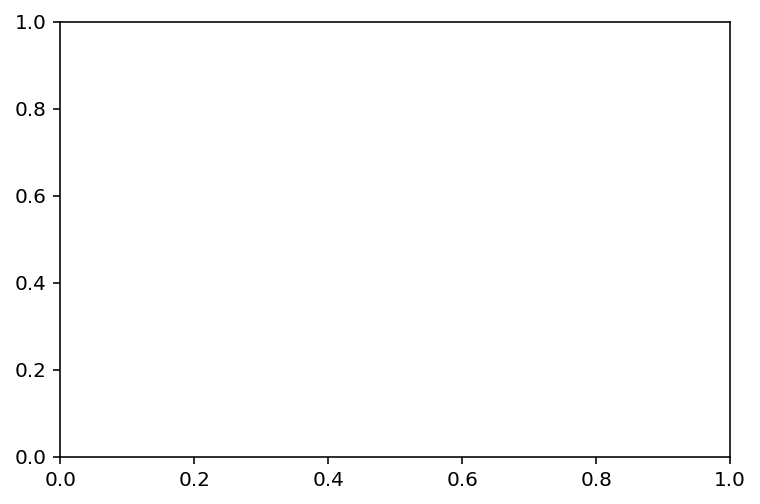

In [534]:
plot_confusion_matrix(predict_train_data)

[[13765   119]
 [  267   714]]
neg acc is: 0.980972
pos acc is: 0.857143


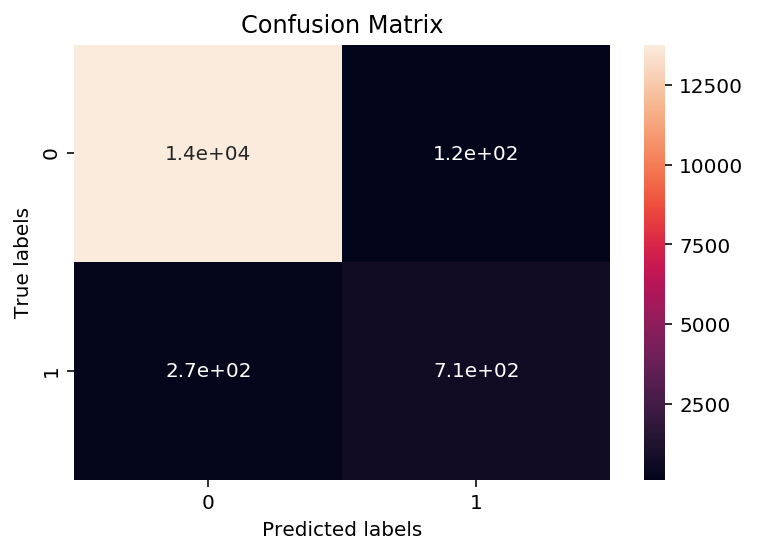

In [488]:
plot_confusion_matrix(predict_train_data)

In [219]:
base_test_data = df_base_info.merge(df_entprise_evaluate, on='id', how='inner')
test_data = base_test_data.merge(df_news_info, on='id', how='left')
test_data = news_info.fill_nan(test_data)
test_data = news_info.convert_data_type(test_data)
# test_data.drop(['id'], inplace=True, axis=1)

In [220]:
test_data.columns

Index(['id', 'oplocdistrict', 'industryphy', 'industryco', 'dom', 'enttype',
       'enttypeitem', 'opfrom', 'opto', 'state', 'orgid', 'jobid', 'adbusign',
       'townsign', 'regtype', 'empnum', 'opform', 'venind', 'enttypeminu',
       'oploc', 'regcap', 'reccap', 'enttypegb', 'diff_year', 'score',
       'total_num', 'middle_num', 'neg_num', 'pos_num', 'max_date_time',
       'min_date_time', 'distinct_count_date_time'],
      dtype='object')

In [222]:
predict_result(lgb_clf, test_data, root + 'result/baseline_9.csv')

In [465]:
class ChangeInfo:
    def __init__(self, data):
        self.data = data
        self.data_type = {
            'total_change_num': 'int64',
            'diff_bgxmdm_num': 'int64',
            'bgq_num': 'int64',
            'bgh_num': 'int64',
            'bgxmdm_bgq_num': 'int64',
            'bgxmdm_bgh_num': 'int64',
            'mean_bgq_as_bgh_num': 'int64',
            'mean_bgh_as_bgq_num': 'int64',
            'change_max_num_day': 'int64',
            'change_min_num_day': 'int64',
            'identification_max_num_day': 'int64',
            'identification_min_num_day': 'int64'
        }
        self.drop_columns = [
                                'bgxmdm',
                                'bgh',
                                'bgq',
                                'bgrq'
                            ]

        self.distinct_features = [
                                      'id',
                                      'total_change_num',
                                      'diff_bgxmdm_num',
                                      'bgq_num',
                                      'bgh_num',
                                      'bgxmdm_bgq_num',
                                      'bgxmdm_bgh_num',
                                      'mean_bgq_as_bgh_num',
                                      'mean_bgh_as_bgq_num',
                                      'change_max_num_day',
                                      'change_min_num_day',
                                      'identification_max_num_day',
                                      'identification_min_num_day'
                                 ]
        return

    def convert_data_type(self, data_frame):
        for name in self.data_type.keys():
            data_frame[name] = data_frame[name].astype(self.data_type[name])
        return

    def spare_time(self):
        self.data['bgrq'] = self.data['bgrq'].apply(lambda x: str(x)[0:10])
        return

    def change_num_day(self):
        """
        同一天(同一时间)变更次数最大值
        同一天(同一时间)变更次数最小值
        :return:
        """
        self.data['index'] = [1] * len(self.data)
        trans_data = self.data[['id', 'bgrq', 'index']].groupby(['id', 'bgrq']).count().reset_index()
        trans_data.drop(['bgrq'], inplace=True, axis=1)
        self.data.drop(['index'], inplace=True, axis=1)
        max_trans_data = trans_data.groupby(['id']).max().reset_index()
        min_trans_data = trans_data.groupby(['id']).min().reset_index()
        max_trans_data.columns = ['id', 'change_max_num_day']
        min_trans_data.columns = ['id', 'change_min_num_day']
        self.data = self.data.merge(max_trans_data, on='id', how='inner')
        self.data = self.data.merge(min_trans_data, on='id', how='inner')
        return

    def identification_num_day(self):
        """
        同一天(同一时间)不同变更代码最大值
        同一天(同一时间)不同变更代码最小值
        :return:
        """
        trans_data = self.data[['id', 'bgrq', 'bgxmdm']].groupby(['id', 'bgrq'])
        trans_data = trans_data.agg({'bgxmdm': pd.Series.nunique}).reset_index()
        trans_data.drop(['bgrq'], inplace=True, axis=1)
        max_trans_data = trans_data.groupby(['id']).max().reset_index()
        min_trans_data = trans_data.groupby(['id']).min().reset_index()
        max_trans_data.columns = ['id', 'identification_max_num_day']
        min_trans_data.columns = ['id', 'identification_min_num_day']
        self.data = self.data.merge(max_trans_data, on='id', how='inner')
        self.data = self.data.merge(min_trans_data, on='id', how='inner')
        return

    # def label_encoder(self):
    #     label_encode = LabelEncoder()
    #     self.data['bgxmdm'] = label_encode.fit_transform(self.data['bgxmdm'])
    #     return

    def total_change_num(self):
        """
        企业变更总次数
        :return:
        """
        self.data['total_change_num'] = [1] * len(self.data)
        trans_data = self.data[['id', 'total_change_num']].groupby(['id']).count().reset_index()
        self.data.drop(['total_change_num'], inplace=True, axis=1)
        self.data = self.data.merge(trans_data, on='id', how='inner')
        return

    def identification_num(self):
        """
        企业不同变更代码个数
        :return:
        """
        trans_data = self.data[['id', 'bgxmdm']].groupby(['id']).agg({'bgxmdm': pd.Series.nunique}).reset_index()
        trans_data.columns = ['id', 'diff_bgxmdm_num']
        self.data = self.data.merge(trans_data, on='id', how='inner')
        return

    def change_before_num(self):
        """
        企业不同bgq个数
        :return:
        """
        trans_data = self.data[['id', 'bgq']].groupby(['id']).agg({'bgq': pd.Series.nunique}).reset_index()
        trans_data.columns = ['id', 'bgq_num']
        self.data = self.data.merge(trans_data, on='id', how='inner')
        return

    def change_after_num(self):
        """
        企业不同bgh个数
        :return:
        """
        trans_data = self.data[['id', 'bgh']].groupby(['id']).agg({'bgh': pd.Series.nunique}).reset_index()
        trans_data.columns = ['id', 'bgh_num']
        self.data = self.data.merge(trans_data, on='id', how='inner')
        return

    def identification_before_num(self):
        """
        企业对应变更代码对应不同bgq平均数
        :return:
        """
        trans_data = self.data[['bgxmdm', 'bgq']].groupby(['bgxmdm'])
        trans_data = trans_data.agg({'bgq': pd.Series.nunique}).reset_index()
        trans_data.columns = ['bgxmdm', 'bgxmdm_bgq_num']
        self.data = self.data.merge(trans_data, on='bgxmdm', how='inner')
        trans_data = self.data[['id', 'bgxmdm_bgq_num']].groupby(['id'])
        trans_data = trans_data.mean().reset_index()
        self.data.drop(['bgxmdm_bgq_num'], inplace=True, axis=1)
        self.data = self.data.merge(trans_data, on='id', how='inner')
        return

    def identification_after_num(self):
        """
        企业对应变更代码对应不同bgh平均数
        :return:
        """
        trans_data = self.data[['bgxmdm', 'bgh']].groupby(['bgxmdm'])
        trans_data = trans_data.agg({'bgh': pd.Series.nunique}).reset_index()
        trans_data.columns = ['bgxmdm', 'bgxmdm_bgh_num']
        self.data = self.data.merge(trans_data, on='bgxmdm', how='inner')
        trans_data = self.data[['id', 'bgxmdm_bgh_num']].groupby(['id'])
        trans_data = trans_data.mean().reset_index()
        self.data.drop(['bgxmdm_bgh_num'], inplace=True, axis=1)
        self.data = self.data.merge(trans_data, on='id', how='inner')
        return

    def before_as_after(self):
        """
        企业bgq作为bgh被使用平均次数
        :return:
        """
        df_bgq = self.data[['bgq']]
        df_bgh = self.data[['bgh']]
        df_bgq.columns = ['change_id']
        df_bgh.columns = ['change_id']

        df_bgq = pd.DataFrame({"change_id": pd.Series(df_bgq['change_id'].unique()).tolist()})
        trans_data = df_bgq.merge(df_bgh, on='change_id', how='inner')
        trans_data['index'] = [1] * len(trans_data)
        trans_data = trans_data.groupby(['change_id']).count().reset_index()
        trans_data.columns = ['bgq', 'bgq_as_bgh_num']
        trans_data = self.data[['id', 'bgq']].merge(trans_data, on='bgq', how='left').fillna(0)

        trans_data.drop(['bgq'], axis=1, inplace=True)
        trans_data = trans_data.groupby(['id']).mean().reset_index()
        trans_data.columns = ['id', 'mean_bgq_as_bgh_num']
        self.data = self.data.merge(trans_data, on='id', how='inner')
        return

    def after_as_before(self):
        """
        企业bgh作为bgq被使用平均次数
        :return:
        """
        df_bgq = self.data[['bgq']]
        df_bgh = self.data[['bgh']]
        df_bgq.columns = ['change_id']
        df_bgh.columns = ['change_id']

        df_bgh = pd.DataFrame({"change_id": pd.Series(df_bgh['change_id'].unique()).tolist()})
        trans_data = df_bgh.merge(df_bgq, on='change_id', how='inner')
        trans_data['index'] = [1] * len(trans_data)
        trans_data = trans_data.groupby(['change_id']).count().reset_index()
        trans_data.columns = ['bgh', 'bgh_as_bgq_num']
        trans_data = self.data[['id', 'bgh']].merge(trans_data, on='bgh', how='left').fillna(0)
        trans_data.drop(['bgh'], axis=1, inplace=True)
        trans_data = trans_data.groupby(['id']).mean().reset_index()
        trans_data.columns = ['id', 'mean_bgh_as_bgq_num']
        self.data = self.data.merge(trans_data, on='id', how='inner')
        return

    def feature_process_v1(self):
        # 行去重
        self.data.drop_duplicates(subset=['id', 'bgxmdm', 'bgq', 'bgh', 'bgrq'], inplace=True)
        # 企业变更次数
        self.total_change_num()
        self.identification_num()
        self.change_before_num()
        self.change_after_num()
        self.identification_before_num()
        self.identification_after_num()
        self.before_as_after()
        self.after_as_before()
        self.change_num_day()
        self.identification_num_day()
        self.convert_data_type(self.data)
        self.data.drop(self.drop_columns, axis=1, inplace=True)
        self.data.drop_duplicates(subset=self.distinct_features, inplace=True)
        return self.data

In [466]:
df_change_info = pd.read_csv(path_change_info)
change_info = ChangeInfo(df_change_info)
change_train_data = change_info.feature_process_v1()